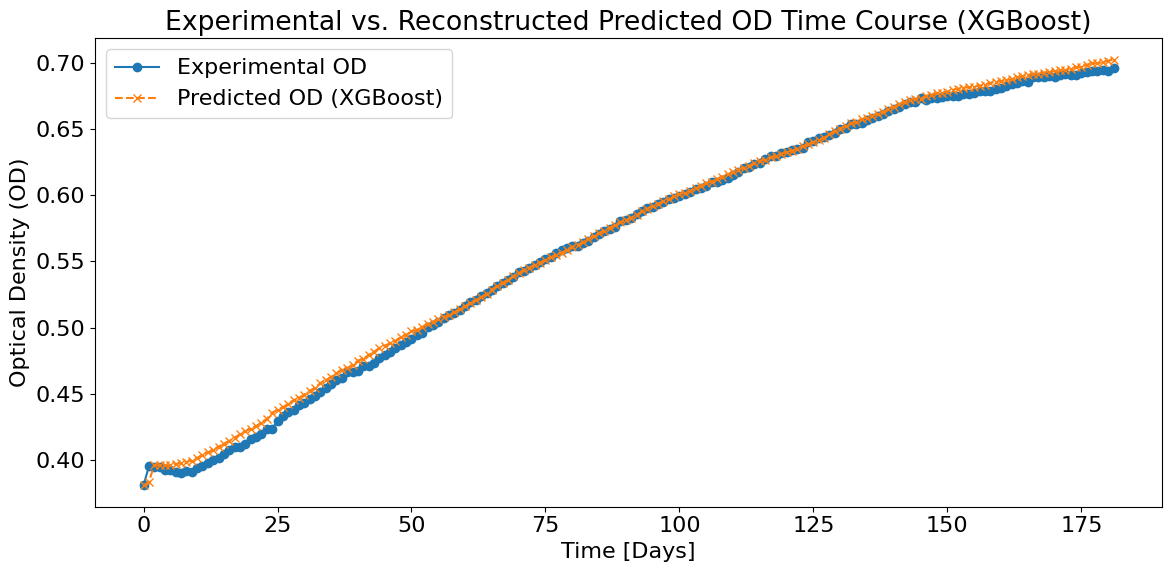

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# --- Load Data ---
summary_statistics_df = pd.read_csv('cyano_culture_datasets/06-03-2025 culture/combined_dataset_summary_statistics.csv')
summary_statistics_df.index = pd.to_datetime(summary_statistics_df.index)

# --- Prepare Features and Target ---
y = summary_statistics_df['delta_OD']
X = summary_statistics_df.drop(columns=['delta_OD', 'OD'])
X_filled = X.fillna(X.mean())
y_aligned = y.loc[X_filled.index]

# --- Model Pipeline ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Cross-validated Predictions ---
delta_od_cv_predictions = cross_val_predict(pipeline, X_filled, y_aligned, cv=cv)

# --- Cap Predictions ---
min_observed_delta_od = y_aligned.min()
max_observed_delta_od = y_aligned.max()
delta_od_cv_predictions_capped = np.clip(delta_od_cv_predictions, min_observed_delta_od, max_observed_delta_od)

# --- OD Time Course Plot ---
initial_actual_od_for_course = summary_statistics_df['OD'].iloc[0] - summary_statistics_df['delta_OD'].iloc[0]
actual_od_course = np.concatenate(([initial_actual_od_for_course], summary_statistics_df['OD'].loc[y_aligned.index].values))

predicted_od_course = [initial_actual_od_for_course]
current_predicted_od = initial_actual_od_for_course
for pred_delta in delta_od_cv_predictions_capped: 
    current_predicted_od += pred_delta
    predicted_od_course.append(current_predicted_od)
predicted_od_course = np.array(predicted_od_course)

plot_timestamps = summary_statistics_df.loc[y_aligned.index].index
if len(plot_timestamps) > 1:
    time_diff = plot_timestamps[1] - plot_timestamps[0]
    initial_timestamp = plot_timestamps[0] - time_diff
elif len(plot_timestamps) == 1:
    initial_timestamp = plot_timestamps[0] - pd.Timedelta(hours=1)
else:
    initial_timestamp = pd.Timestamp.now() - pd.Timedelta(hours=1)
# Generate day numbers for x-axis instead of timestamps
full_plot_timestamps = np.arange(len(summary_statistics_df) + 1)  # +1 for initial OD point

plt.rcParams.update({'font.size': 16})

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(full_plot_timestamps, actual_od_course, label='Experimental OD', marker='o', linestyle='-')
plt.plot(full_plot_timestamps, predicted_od_course, label='Predicted OD (XGBoost)', marker='x', linestyle='--')
plt.xlabel("Time [Days]")
plt.ylabel("Optical Density (OD)")
plt.title("Experimental vs. Reconstructed Predicted OD Time Course (XGBoost)")
plt.legend()
plt.grid(False)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 




--- Training and Evaluating XGBoost Model with 10-Fold Cross-Validation ---

Cross-Validation Model Evaluation Metrics (10-fold):
  Mean Squared Error (MSE): 0.0000 (+/- 0.0000)
  Root Mean Squared Error (RMSE): 0.0018
  Mean Absolute Error (MAE): 0.0010 (+/- 0.0004)
  R-squared (R²): -0.5169 (+/- 1.6198)


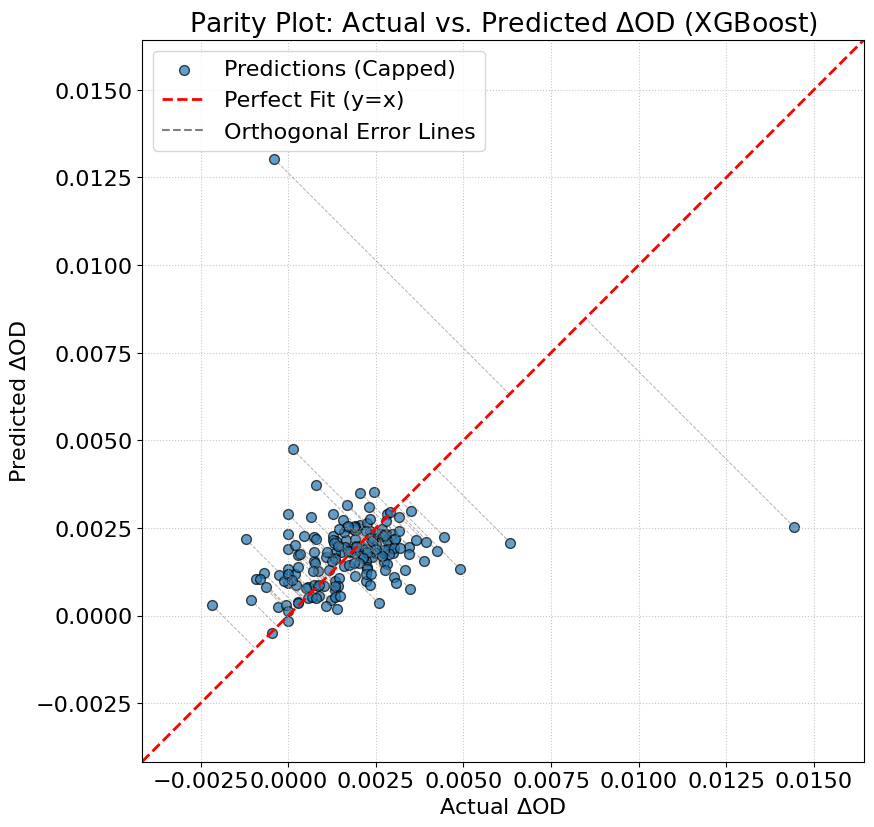

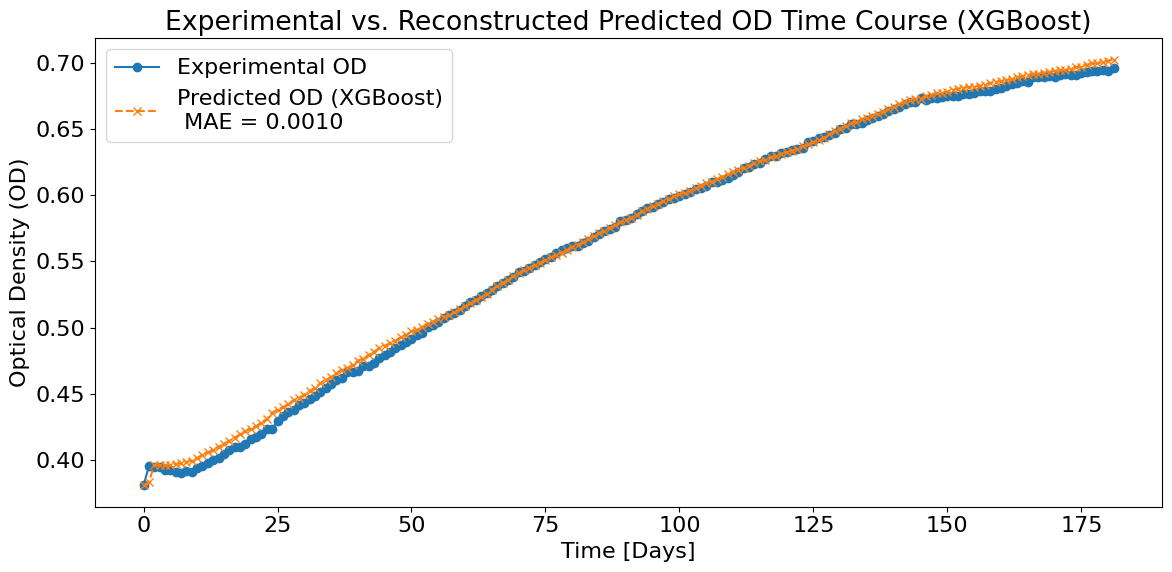


--- Training Final Model on All Data for Feature Importance ---

Feature Importance:
                                              Feature  Importance
                                           Unnamed: 0    0.275277
                          min_Dissolved Oxygen (mg/L)    0.116163
                                 mean_Temperature (C)    0.061474
                          std_Dissolved Oxygen (mg/L)    0.054541
                                               min_pH    0.053939
                      first_last_diff_Temperature (C)    0.053931
                                  std_Temperature (C)    0.052223
                        slope_Dissolved Oxygen (mg/L)    0.043423
                                slope_Temperature (C)    0.041052
                                               std_pH    0.039583
              first_last_diff_Dissolved Oxygen (mg/L)    0.037199
                                            median_pH    0.035913
                          max_Dissolved Oxygen (mg/L)   

In [44]:
train_and_evaluate_xgboost(summary_statistics_df)


In [45]:
print(summary_statistics_df.index[:5])
print(summary_statistics_df.index.dtype)
print(summary_statistics_df.loc[y_aligned.index].index[:5])


DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)
datetime64[ns]
DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004'],
              dtype='datetime64[ns]', freq=None)


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rcParams.update({'font.size': 16})

def train_and_evaluate_xgboost(features_df):
    print("\n--- Training and Evaluating XGBoost Model with 10-Fold Cross-Validation ---")
    
    if features_df.empty or len(features_df) < 10:
        print("Not enough data for 10-fold CV.")
        return

    y = features_df['delta_OD']
    X = features_df.drop(columns=['delta_OD', 'OD'])
    X_filled = X.fillna(X.mean())

    y_aligned = y.loc[X_filled.index]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
    ])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    # CV metrics
    mse_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_squared_error', cv=cv)
    mae_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='r2', cv=cv)

    print("\nCross-Validation Model Evaluation Metrics (10-fold):")
    print(f"  Mean Squared Error (MSE): {-np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
    print(f"  Root Mean Squared Error (RMSE): {np.sqrt(-np.mean(mse_scores)):.4f}")
    print(f"  Mean Absolute Error (MAE): {-np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
    print(f"  R-squared (R²): {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")
    cv_mae = -np.mean(mae_scores)  # Already done in your code
    std_dev_mae = np.std(mae_scores)

    delta_od_cv_predictions = cross_val_predict(pipeline, X_filled, y_aligned, cv=cv)

    # Cap predictions
    lower = y_aligned.min()
    upper = y_aligned.max()
    delta_od_cv_predictions_capped = np.clip(delta_od_cv_predictions, lower, upper)

    # Parity plot
    plt.figure(figsize=(9, 9))
    scatter_points = plt.scatter(y_aligned, delta_od_cv_predictions_capped, alpha=0.7, edgecolors='k', s=50)
    for actual, pred in zip(y_aligned, delta_od_cv_predictions_capped):
        mid = (actual + pred) / 2
        plt.plot([actual, mid], [pred, mid], color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
    min_val = min(y_aligned.min(), delta_od_cv_predictions_capped.min()) - 0.002
    max_val = max(y_aligned.max(), delta_od_cv_predictions_capped.max()) + 0.002
    line = plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.ylabel(r'Predicted $\Delta$OD')
    plt.xlabel(r'Actual $\Delta$OD')
    plt.title("Parity Plot: Actual vs. Predicted $\Delta$OD (XGBoost)")
    plt.legend([scatter_points, line[0], Line2D([0], [0], color='gray', linestyle='--')],
               ['Predictions (Capped)', 'Perfect Fit (y=x)', 'Orthogonal Error Lines'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # OD time course
    if not features_df.empty and not y_aligned.empty: 
        initial_od = features_df['OD'].iloc[0] - features_df['delta_OD'].iloc[0]
        actual_od = np.concatenate(([initial_od], features_df['OD'].loc[y_aligned.index].values))

        predicted_od = [initial_od]
        current = initial_od
        for delta in delta_od_cv_predictions_capped:
            current += delta
            predicted_od.append(current)
        predicted_od = np.array(predicted_od)

        time_points = np.arange(len(predicted_od))
        plt.figure(figsize=(12, 6))
        # Calculate final MAE for OD values
        #mae_od_course = mean_absolute_error(actual_od_course[1:], predicted_od_course[1:])  # skip initial value

        # Plot with MAE included in legend
        plt.plot(full_plot_timestamps, actual_od_course, label='Experimental OD', marker='o', linestyle='-')
        plt.plot(full_plot_timestamps, predicted_od_course,
         label=f'Predicted OD (XGBoost)\nMAE = {cv_mae:.4f} +/- {std_dev_mae:.4f}',
         marker='x', linestyle='--')

        plt.xlabel("Time [Days]")
        plt.ylabel("Optical Density (OD)")
        plt.title("Experimental vs. Reconstructed Predicted OD Time Course (XGBoost)")
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    # Feature importance
    print("\n--- Training Final Model on All Data for Feature Importance ---")
    pipeline.fit(X_filled, y_aligned)
    model = pipeline.named_steps['regressor']
    importance = model.feature_importances_
    feature_names = X_filled.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Importance:")
    print(importance_df.to_string(index=False))



--- Training and Evaluating XGBoost Model with 10-Fold Cross-Validation ---

Cross-Validation Model Evaluation Metrics (10-fold):
  Mean Squared Error (MSE): 0.0000 (+/- 0.0000)
  Root Mean Squared Error (RMSE): 0.0018
  Mean Absolute Error (MAE): 0.0010 (+/- 0.0004)
  R-squared (R²): -0.5169 (+/- 1.6198)


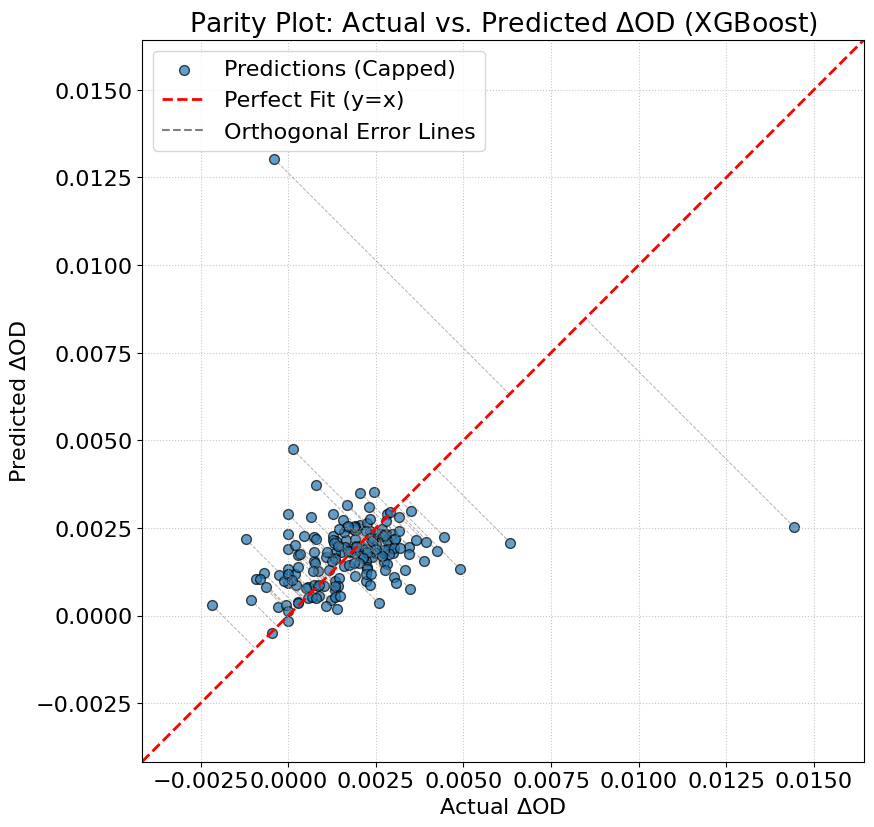

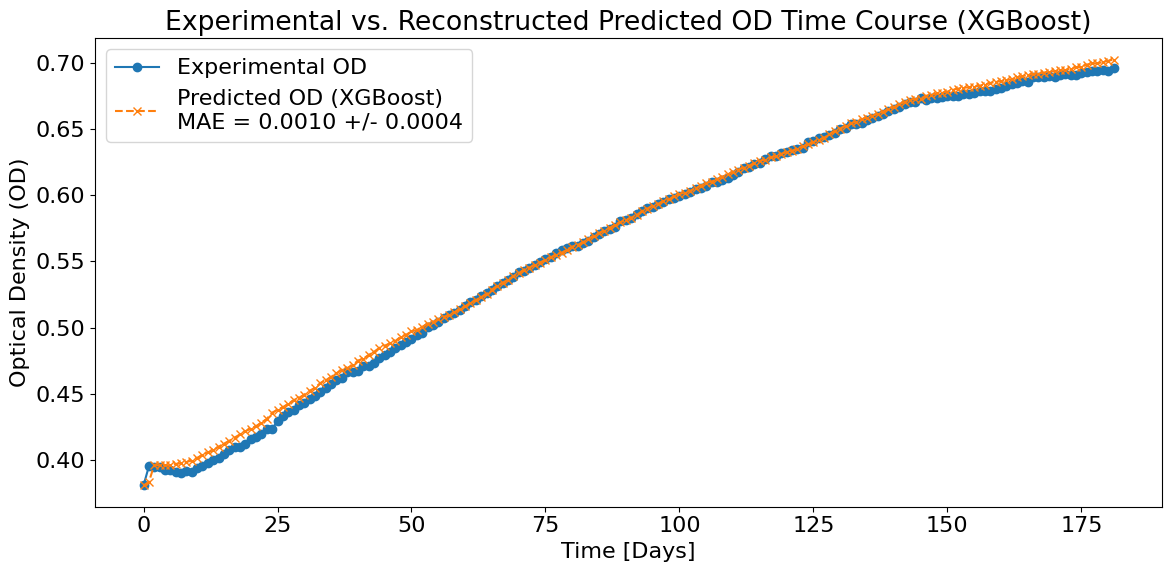


--- Training Final Model on All Data for Feature Importance ---

Feature Importance:
                                              Feature  Importance
                                           Unnamed: 0    0.275277
                          min_Dissolved Oxygen (mg/L)    0.116163
                                 mean_Temperature (C)    0.061474
                          std_Dissolved Oxygen (mg/L)    0.054541
                                               min_pH    0.053939
                      first_last_diff_Temperature (C)    0.053931
                                  std_Temperature (C)    0.052223
                        slope_Dissolved Oxygen (mg/L)    0.043423
                                slope_Temperature (C)    0.041052
                                               std_pH    0.039583
              first_last_diff_Dissolved Oxygen (mg/L)    0.037199
                                            median_pH    0.035913
                          max_Dissolved Oxygen (mg/L)   

In [47]:
train_and_evaluate_xgboost(summary_statistics_df)
